## <a id='table-of-contents'></a>Table of contents
1. [Import Libraries](#imports)
2. [Load Data](#load-data)
3. [Pre-processing: Scans](#scan-info)
4. [Pre-processing: Errors](#error-info)
5. [Motor 1 EDA](#m1-info)
6. [Motor 2 EDA](#m2-info)
7. [Conversion: Time Delay](#time-delay)
8. [Figure 1: No Dash](#figure1)
9. [Figure 2: Option3](#figure2)
10. [Figure 3: Not my figure](#figure3)
11. [Figure 4: Subplots](#figure4)

### Import Libraries and Modules


In [34]:
# Data Manipulation, Wrangling & Analysis Library 
import pandas as pd
# Multi-Dimensional Arrays and Matrices Library
import numpy as np
# Plotting module from Matplotlib visualization Library
#import matplotlib.pyplot as plt
# Statistical data visualization library built on Matplotlib
#import seaborn as sns
# Import physical constants such as the speed of light
import scipy.constants as consts

In [35]:
from jupyter_dash import JupyterDash
from jupyterthemes import jtplot

#jtplot.style(theme='solarizedd', context='notebook', ticks=True, grid=False)

In [36]:
# Import axes_grid1 toolkit to display multiplot w/ AxesGrid helper class
#from mpl_toolkits.axes_grid1 import AxesGrid
#from mpl_toolkits.axes_grid1 import host_subplot

In [37]:
# Quick and dirty method
import plotly.express as px # (version 4.7.0)

# For more customization
import plotly.graph_objects as go

# Make subplots
from plotly.subplots import make_subplots

# Dashboard Library 'Dash' allows for button interactivity through callbacks
import dash  # (version 1.12.0) pip install dash
import dash_core_components as dcc
import dash_html_components as html
import dash_daq as daq
from dash.dependencies import Input, Output, State
#from dash.dependencies import ALL, MATCH, ALLSMALLER


#### Render Plotly graphs in JupyterLab Notebook
[*Stack Overflow*](https://stackoverflow.com/questions/54936125/plotly-gives-an-empty-field-as-output-in-jupyter-lab)

JupyterLab Version >= 3.0.0:<br> 
$ jupyter labextension install jupyterlab-plotly

Verify:<br>
$ jupyter labextension list
---

<a id = 'load-data'></a>
### Load Data

[[ go back to the top ]](#Table-of-contents)

In [38]:
# Identify column names for new DataFrame
header_names = ['#errors',
                'scan#', 
                'motor-target_1', # Motor-1 targeted motor position
                'motor-target_2', # Motor-2 targeted motor position
                'motor-actual_1', # Motor-1 actual recorded position
                'motor-actual_2', # Motor-2 actual recorded position
                'data_channel_0', 
                'data_channel_1', 
                'data_channel_2',
                'data_channel_3',
                'data_channel_4',
                'data_channel_5',
                'data_channel_6',
                'data_channel_7']

# Read tsv data and assign to a Pandas DataFrame
data = pd.read_csv('../data/trial_output05.tsv', delimiter='\t', names = header_names)

# Set dtype of scan# column to int32
data = data.astype({'scan#':int})

#### Check that all is copacetic

[[ go back to the top ]](#Table-of-contents)

In [39]:
# motor-target_1: Corresponds to Delay-Axis 1 "T"  PUMP TO DRIVE/PROBE PAIR
# motor-target_2: Corresponds to Delay-Axis 2 "Tau" DRIVE TO PROBE
data.describe()

,#errors,scan#,motor-target_1,motor-target_2,motor-actual_1,motor-actual_2,data_channel_0,data_channel_1,data_channel_2,data_channel_3,data_channel_4,data_channel_5,data_channel_6,data_channel_7
count,45628.0,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000
mean,0.0,5.378978,9.314018,33.425522,9.314025,33.425522,-0.005923,-0.006613,-0.006294,-0.006124,-0.007194,-0.006101,-0.021113,0.004937
std,0.0,3.390998,0.058022,0.050232,0.058011,0.050232,0.006699,0.022854,0.005250,0.010072,0.022253,0.009477,0.014158,0.015740
min,0.0,0.000000,9.215000,33.340000,9.215000,33.340000,-0.032503,-0.063398,-0.031538,-0.047629,-0.058893,-0.037974,-0.032503,-0.025745
25%,0.0,2.000000,9.263000,33.382000,9.263000,33.382000,-0.010298,-0.027033,-0.009654,-0.013194,-0.027033,-0.012229,-0.022849,0.003219
50%,0.0,5.000000,9.314000,33.427000,9.314000,33.427000,-0.006436,-0.008689,-0.006436,-0.007080,-0.009976,-0.007401,-0.021240,0.004828
75%,0.0,8.000000,9.365000,33.469000,9.365000,33.469000,-0.000965,0.012873,-0.002252,0.000644,0.011586,0.001288,-0.019631,0.006115
max,0.0,11.000000,9.413000,33.511000,9.413100,33.511000,0.018022,0.059537,0.016735,0.039906,0.056963,0.025424,1.671540,1.827301


---
<a id = 'scan-info'></a>

### Identify number of complete scans performed

[[ go back to the top ]](#table-of-contents)

In [40]:
# Identify # of complete scans performed
scan_info = data['scan#'].value_counts().sort_index()
num_scans = len(scan_info)
complete = max(scan_info)
complete_scans = []
incomplete_scans = []

# Count the number of measurements taken in each scan
num_m1steps = len(data['motor-target_1'].value_counts())
# Count the number of measurements taken in each scan
num_m2steps = len(data['motor-target_2'].value_counts())

# Requirements for complete scan
print(f'Complete scans have {num_m1steps*num_m2steps:,} measurements!\n')

print('scan# complete%')
display(round((data['scan#'].value_counts().sort_index()/(num_m1steps*num_m2steps))*100, 2))
print()

# Identify incomplete scans
for scan in range(num_scans):
    if scan_info[scan] != complete:
        incomplete_scans.append(scan)
    elif scan_info[scan] == complete:
        complete_scans.append(scan)
print(f'INCOMPLETE scan#: {incomplete_scans}')  
print(f'COMPLETE scan#:   {complete_scans}')  

Complete scans have 3,886 measurements!

scan# complete%


0     100.00
1     100.00
2     100.00
3     100.00
4     100.00
5     100.00
6     100.00
7     100.00
8     100.00
9     100.00
10    100.00
11     74.16
Name: scan#, dtype: float64


INCOMPLETE scan#: [11]
COMPLETE scan#:   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


---
<a id='error-info'></a>
### Check for Errors

[[ go back to the top ]](#table-of-contents)

In [41]:
# No errors identified in 45,628 measurements!
# An error may consist of a communication error b/w motor & acquisition computer
# Motors will be reinitialized, and the scan is restarted
data['#errors'].value_counts()

0.0    45628
Name: #errors, dtype: int64

---
### EDA: Characterize each Delay-Axis by Motor-Position(target)
* How many measurements were taken?
* What range was covered?
* What is the step-size of each scan?

<a id = 'm1-info'></a>
#### A.) Consider Motor-1 Targets

[ go back to the top ](#table-of-contents)

In [42]:
# Display Motor_1 Description
print(f'Motor-1 Targets: \n')

# Pre-Processing
m1_positions = sorted(data['motor-target_1'].unique())

# Determine the range of Motor_1 positions
m1_position_min = m1_positions[0]
m1_position_max = m1_positions[-1]
m1_position_range = round(m1_position_max - m1_position_min,3)

print(f'\
        Min: {m1_position_min}[mm]\n\
        Max: {m1_position_max}[mm]\n\
        Range: {m1_position_range}[mm]')

# Display the number of measurements taken in each scan
print(f'\tNo. of Steps: {num_m1steps}')

Motor-1 Targets: 

        Min: 9.215[mm]
        Max: 9.413[mm]
        Range: 0.198[mm]
	No. of Steps: 67


<a id = 'm2-info'></a>

#### B.) Consider Motor-2 Targets


In [43]:
# Display Motor-2 Description
print(f'Motor-2 Targets: \n')

# Pre-Processing
m2_positions = sorted(data['motor-target_2'].unique())

# Determine the range of Motor_1 positions
m2_position_min = m2_positions[0]
m2_position_max = m2_positions[-1]
m2_position_range = round(m2_position_max - m2_position_min, 3)

print(f'\
        Min: {m2_position_min}[mm]\n\
        Max: {m2_position_max}[mm]\n\
        Range: {m2_position_range}[mm]')

# Display the number of measurements taken in each scan
print(f'\tNo. of Steps: {num_m2steps}')

Motor-2 Targets: 

        Min: 33.34[mm]
        Max: 33.511[mm]
        Range: 0.171[mm]
	No. of Steps: 58


---
<a id = 'time-delay'></a>
### Conversion: Motor-Position [mm] to Time-Delay [fs]

[[ go back to the top ]](#table-of-contents)

#### A) Delay Axis-1: T 
##### Delay between the excitation(pump) pulse and subsequent pulses

In [44]:
# Step-size for Delay Axis-1: Round for sigfigs
sigfigs = 3
step1_space = round(m1_position_range/num_m1steps, sigfigs)

# Time, in femtoseconds[fs], it takes light to travel twice the distance "step_1"
# One femtosecond in [seconds]:
fs = 1E-15
# One thousand
K = int(1E3)
# Speed of light in [meters/second]
c = consts.c
# Laser travels twice the motor distance
twice = 2

step1_time = round((step1_space*twice / (c*K))/fs, 1)
range_T = step1_time*num_m1steps

print(f'Motor-1 Step-Size:   {step1_space}[mm]  =>  ~ {step1_time}[fs]')
print(f'Pump-Probe Time-Delay "T" Range:  ~{range_T:,}[fs]')

Motor-1 Step-Size:   0.003[mm]  =>  ~ 20.0[fs]
Pump-Probe Time-Delay "T" Range:  ~1,340.0[fs]


#### B) Delay Axis-2: <font size="5">$\tau$</font>
##### Delay between Kerr-Gating(drive) pulse and probe pulse

In [45]:
# Step-size for Delay Axis-2: Round for sigfigs
sigfigs = 3
step2_space = round(m2_position_range/num_m2steps, sigfigs)

# Time [femtoseconds] it takes light to travel twice the distance "step_2"
step2_time = round( (step2_space*twice/(c*K))/fs, 1)
range_tau = step2_time*num_m2steps

print(f'Motor-2  Step-Size:   {step2_space}[mm]  =>   ~ {step2_time}[fs]')
print(f'Drive-Probe Time-Delay "TAU" Range: ~{range_tau:,}[fs]')
print(f'Drive-Probe Time-Delay "$\tau$" Range: ~{range_tau:,}[fs]')



Motor-2  Step-Size:   0.003[mm]  =>   ~ 20.0[fs]
Drive-Probe Time-Delay "TAU" Range: ~1,160.0[fs]
Drive-Probe Time-Delay "$	au$" Range: ~1,160.0[fs]


In [46]:
greek_char_names = ['\N{GREEK CAPITAL LETTER TAU}',
                    '\N{GREEK SMALL LETTER TAU}',
                    '\N{GREEK CAPITAL LETTER TAU}',
                    '\N{GREEK SMALL LETTER TAU}',
                    '\N{MATHEMATICAL BOLD CAPITAL TAU}',
                    '\N{MATHEMATICAL BOLD SMALL TAU}',
                    '\N{MATHEMATICAL ITALIC CAPITAL TAU}',
                    '\N{MATHEMATICAL ITALIC SMALL TAU}',
                    '\N{MATHEMATICAL BOLD ITALIC CAPITAL TAU}',
                    '\N{MATHEMATICAL BOLD ITALIC SMALL TAU}']
for name in greek_char_names:
    print(name)

Τ
τ
Τ
τ
𝚻
𝛕
𝛵
𝜏
𝜯
𝝉


---

In [47]:
# Identify range of signal amplitudes
data_cols = [col_name for col_name in data if 'data_channel' in col_name]
signal_df = data[data_cols]

# WARNING: Dropping columns in signal_df will remove those channels from the figure display
nchannels = len(signal_df.columns)

# Identify the max and min signal strength
v_min = min(signal_df.min())
v_max = max(signal_df.max())

print(f'Minimum: {v_min}\nMaximum: {v_max}')

Minimum: -0.063398
Maximum: 1.827301


In [48]:
signal_mins = []
signal_maxs = []
for col in signal_df.columns:
    signal_mins.append(round(min(signal_df[col]),4))
    signal_maxs.append(round(max(signal_df[col]),4))
print(f'Signal Minimums by channel: {signal_mins}')
print(f'Signal Maximums by channel: {signal_maxs}')

Signal Minimums by channel: [-0.0325, -0.0634, -0.0315, -0.0476, -0.0589, -0.038, -0.0325, -0.0257]
Signal Maximums by channel: [0.018, 0.0595, 0.0167, 0.0399, 0.057, 0.0254, 1.6715, 1.8273]


In [49]:
signal_mins

[-0.0325, -0.0634, -0.0315, -0.0476, -0.0589, -0.038, -0.0325, -0.0257]

In [50]:
signal_maxs

[0.018, 0.0595, 0.0167, 0.0399, 0.057, 0.0254, 1.6715, 1.8273]

In [51]:
#for i in range(len(data_cols)):
    

In [52]:
signal_df

,data_channel_0,data_channel_1,data_channel_2,data_channel_3,data_channel_4,data_channel_5,data_channel_6,data_channel_7
0,0.013195,0.010942,-0.006436,-0.019309,-0.031860,-0.005470,1.671540,1.827301
1,0.003862,0.014804,0.000322,-0.010620,-0.024458,-0.008689,1.370637,1.558580
2,0.000644,-0.035400,-0.016412,-0.009332,0.010299,0.009333,1.125409,1.304020
3,-0.004827,-0.036043,-0.007401,-0.010620,0.028321,0.005793,0.923627,1.082929
4,0.001288,-0.008367,-0.008689,-0.010941,-0.025423,-0.010298,0.755637,0.894985
...,...,...,...,...,...,...,...,...
45623,-0.001609,-0.032503,-0.016091,-0.014481,0.001931,0.007081,-0.018987,0.005793
45624,-0.013516,-0.020274,-0.005149,-0.005149,0.004184,-0.006436,-0.016734,0.008368
45625,-0.017700,-0.037009,-0.009654,0.003219,0.020275,-0.003540,-0.016412,0.008046
45626,-0.019309,-0.037974,-0.009654,0.004828,0.022528,-0.003540,-0.015769,0.009977


In [53]:
# slct_scan = 'scan#7'
# slct_channel = 7
# min_min = data_dict[slct_scan][slct_channel].min().min()
# abs_min = abs(min_min)
# abs_min
# max_max = data_dict[slct_scan][slct_channel].max().max()
# abs_max = abs(max_max)
# print(f'abs_max
# if abs_min > abs_max:
#     print('True Min')
#     dff_min = min_min
#     dff_max = -1*min_min
#     print(f'Real: {max_max}, dff_max: {dff_max}')
# elif abs_min < abs_max:
#     print('True Max')
#     dff_min = -1*max_max
#     dff_max = max_max
#     print(f'Real: {min_min}, dff_min: {dff_min}')
# dff_min
# dff_max

---
### Data Dictionary
    Keys : Scan #
    Vals : Channel DataFrames

#### Each DF Channel List [0, 1, 2, ...]
1. Motor-1 (xaxis): <b>Columns</b><br>
    FIXED T: Pump-Probe Delay<br><br>
2. Motor-2 (yaxis): <b>Rows</b><br>
    FIXED <font size="3">$\tau$</font>: Drive-Probe Delay

In [54]:
# Set-up lists to store delay scan DataFrames for each channel (0-7)
data_to_plot = []

# Average all scans together
data_mean = data.groupby(['motor-target_1', 'motor-target_2']).mean()

# data_to_plot
for channel in range(nchannels):
    # Append data for each channel
    data_to_plot.append(data_mean['data_channel_'+str(channel)].reset_index().pivot(index='motor-target_2', columns='motor-target_1'))
    
    # Rename multi-indexed columns so they are not tuples of the format ('data_channel_x', <motor-target_1>)
    data_to_plot[channel].columns = data_to_plot[channel].columns.droplevel(0)
    
# Initialize 'data dictionary' to keep track of all complete scans and the average of all scans(A.K.A 'data_mean')
data_dict = {'scan_avg':data_to_plot}

In [55]:
for scan in complete_scans:
    dummy_scan_list = []
    data_scan = data[data['scan#']==scan].copy()
    data_scan = data_scan.groupby(['motor-target_1', 'motor-target_2']).mean().copy()
    
    for channel in range(nchannels):
        # Append data for each channel
        dummy_scan_list.append(data_scan['data_channel_'+str(channel)].reset_index().pivot(index='motor-target_2', columns='motor-target_1'))
        # Rename multi-indexed columns so they are not tuples of the format ('data_channel_x', <motor-target_1>)
        dummy_scan_list[channel].columns = dummy_scan_list[channel].columns.droplevel(0)
    # Append scan to data_dict
    data_dict['scan#'+str(scan)] = dummy_scan_list

In [56]:
# Check that all is copacetic
data_dict.keys()

dict_keys(['scan_avg', 'scan#0', 'scan#1', 'scan#2', 'scan#3', 'scan#4', 'scan#5', 'scan#6', 'scan#7', 'scan#8', 'scan#9', 'scan#10'])

---
# Do I need this block?

In [57]:
# Clean up tick-labels on ALL axes
motor_labels = [0]
tick_idx = [0]
for stage in range(1,3):
    s = data['motor-target_'+str(stage)]
    last = len(s.unique())-1
    midd = round(last/2)
    motor_labels.append([s.min(), s.quantile(q=0.5), s.max()])
    tick_idx.append([0, midd, last])
motor_labels

[0, [9.215, 9.314, 9.413], [33.34, 33.427, 33.511]]

---

In [58]:
# Motor One
motor1_labels = motor_labels[1]
m1_tick_idx  = tick_idx[1]
print(f'X-tick positions "m1_tick_idx": {m1_tick_idx}')

# Motor Two
motor2_labels = motor_labels[2]
m2_tick_idx  = tick_idx[2]
print(f'Y-tick positions "m2_tick_idx": {m2_tick_idx}')

X-tick positions "m1_tick_idx": [0, 33, 66]
Y-tick positions "m2_tick_idx": [0, 28, 57]


In [59]:
# Specify initial time-zero tick-position (1st guess midpoint of data)
tz1 = m1_tick_idx[1]
tz2 = m2_tick_idx[1]
# Specify time delta for labeling child axes
T_labels = [round((m1_tick_idx[i]-tz1)*step1_time) for i in range(len(motor1_labels))]
tau_labels = [round((m2_tick_idx[i]-tz2)*step2_time) for i in range(len(motor2_labels))]
print(f'2nd x-axis tick-labels "T_labels": {T_labels}')
print(f'2nd y-axis tick-labels "\N{mathematical bold italic small tau}_labels": {tau_labels}')

2nd x-axis tick-labels "T_labels": [-660, 0, 660]
2nd y-axis tick-labels "𝝉_labels": [-560, 0, 580]


#### Define time axes

[[ go back to the top ]](#Table-of-contents)

In [60]:
# Pre-Processing

# Any channel will work the same in this cell block
df = data_to_plot[0]

# Identify INDEX of the Motor-1 position associated with Time-Overlap
if (num_m1steps%2) == 0:
    step1_zero = int(num_m1steps/2)
elif (num_m1steps%2) != 0:
    step1_zero = int((num_m1steps-1)/2)
    
# Identify INDEX of the Motor-2 position associated with Time-Overlap
if (num_m2steps%2) == 0:
    step2_zero = int(num_m2steps/2)
elif (num_m2steps%2) != 0:
    step2_zero = int((num_m2steps-1)/2)
    
val1_zero = df.columns.to_list()[step1_zero]
val2_zero = df.index.to_list()[step2_zero]

# Round arrays with Numpy
time_ax1 = np.round( (df.columns-val1_zero)/step1_space*step1_time, 1)
time_ax2 = np.round( (df.index - val2_zero)/step2_space*step2_time, 1)

In [61]:
time_ax1

Float64Index([-660.0, -640.0, -620.0, -600.0, -580.0, -560.0, -540.0, -520.0,
              -500.0, -480.0, -460.0, -440.0, -420.0, -400.0, -380.0, -360.0,
              -340.0, -320.0, -300.0, -280.0, -260.0, -240.0, -220.0, -200.0,
              -180.0, -160.0, -140.0, -120.0, -100.0,  -80.0,  -60.0,  -40.0,
               -20.0,    0.0,   20.0,   40.0,   60.0,   80.0,  100.0,  120.0,
               140.0,  160.0,  180.0,  200.0,  220.0,  240.0,  260.0,  280.0,
               300.0,  320.0,  340.0,  360.0,  380.0,  400.0,  420.0,  440.0,
               460.0,  480.0,  500.0,  520.0,  540.0,  560.0,  580.0,  600.0,
               620.0,  640.0,  660.0],
             dtype='float64', name='motor-target_1')

In [62]:
time_ax2

Float64Index([-580.0, -560.0, -540.0, -520.0, -500.0, -480.0, -460.0, -440.0,
              -420.0, -400.0, -380.0, -360.0, -340.0, -320.0, -300.0, -280.0,
              -260.0, -240.0, -220.0, -200.0, -180.0, -160.0, -140.0, -120.0,
              -100.0,  -80.0,  -60.0,  -40.0,  -20.0,    0.0,   20.0,   40.0,
                60.0,   80.0,  100.0,  120.0,  140.0,  160.0,  180.0,  200.0,
               220.0,  240.0,  260.0,  280.0,  300.0,  320.0,  340.0,  360.0,
               380.0,  400.0,  420.0,  440.0,  460.0,  480.0,  500.0,  520.0,
               540.0,  560.0],
             dtype='float64', name='motor-target_2')

---
<a id='figure1'></a>
# Plotly Figure 1

> No Dash Interactivity between buttons

[ go back to the top ](#table-of-contents)

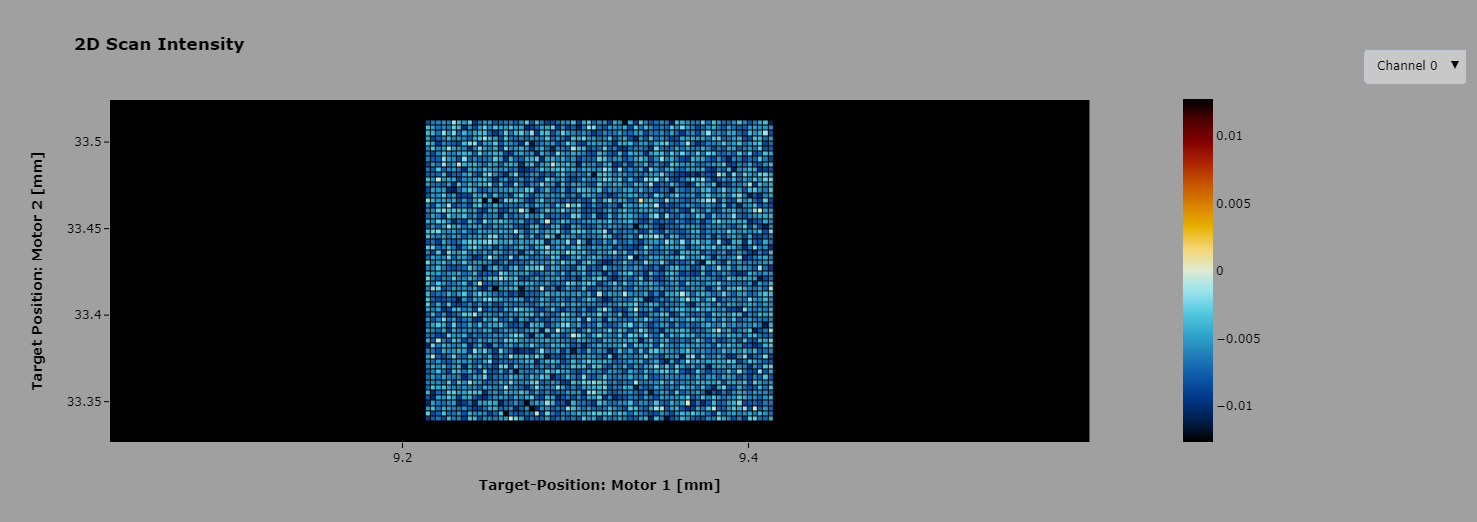

In [63]:
### import plotly.graph_objects as go
# go objects are grouped into 'one-indexed' subplot rows
# Set hmap magnification, fixed ratio
mag_factor = 9

# Set base figure for subplots
fig = make_subplots(rows = 1, #Display how many rows of objects 
                    cols = 1, #Display how many side-by-side?
                    #subplot_titles = [list_of_strings],
                    specs=[[{'secondary_y':True}]],
                    shared_xaxes = False,
                    shared_yaxes = False)

# Add heatmap traces for each channel
for ch in range(nchannels):
    df = data_to_plot[ch]
    fig.add_trace(go.Heatmap(x = df.columns,
                             xgap = 1,
                             y = df.index,
                             ygap = 1,
                             z = df, # Signal data of channel = ch
                             zmin = signal_mins[ch], # Specify or plotly defaults to df min/max
                             zmid = 0,
                             #zmax = signal_maxs[ch],
                             #colorbar_title = f'<b>Ch {ch}<b>',
                             #colorbar_tickcolor = 'black',
                             colorbar_len = 1.06,
                                         #'xpad': 100},
                                         #'x': cbar_xlocs[ch],
                                         #'y': cbar_ylocs[ch],
                             colorscale ='icefire'),
                  #row = mth_row,
                  #col = nth_col,
                  #name = f'Channel {ch}',
                  secondary_y = False)
#########################################################################################################################################
# Update layout by embedding dropdown buttons in the updatemenu
dropdown_buttons = []
for ch in range(nchannels):
    dropdown_buttons.append({'label': f'Channel {ch}',
                             'method': 'update',
                             'args': [
                                      {'visible': [idx==ch for idx in range(nchannels)] },
                                      {'title': '<b>2D Scan Intensity<b>'}
                                     ]
                            })
    
# Initial display: Hide all traces after channel zero
for i in range(1, nchannels):
    fig.data[i].visible = False

# Implement a dropdown button
fig.update_layout(
                  {'updatemenus': [{'type': 'dropdown',
                                    'x': 1.3, # Position floats 
                                    'y': 1.15, # Position floats 
                                    'showactive': True, # Active buttons are highlighted
                                    'active': 0, # Determines initial 'active' channel
                                    'bgcolor': 'rgb(200,200,200)',
                                    'direction': 'down',
                                    'buttons': dropdown_buttons}] 
                  }) 
######################################################################################################################################
## Add secondary axes
#fig.add_trace(go.Heatmap(x = df.columns,
#                         y = time_ax2, # Tau Delay-Axis (Motor-2), displayed 'Right'
#                         z = df, # Signal data of channel = ch
#                         #zmin = signal_mins[ch], # Specify or plotly defaults to df min/max 
#                         #zmax = signal_maxs[ch],
#                         colorscale = 'icefire'),
#              #row = mth_row,
#              #col = nth_col,
#              #yaxis = 'y2',
#              secondary_y = True)

# Format Axes
fig.update_layout(
                  {'xaxis':{'title' : {'text' : '<b>Target-Position: Motor 1 [mm]<b>'},
                            #'tickmode': 'auto',
                            'nticks' : 5,
                            'ticks' : 'outside',
                            #'tickson': 'boundaries',
                            #'ticklabelposition': 'outside top',
                            'side': 'bottom',
                            #'tick0': motor_labels[1][0],
                            #'dtick': round(step1_space, 3)*11,# *num_m1steps*.5,
                            'showticklabels': True,
                            'color' : 'black',
                            #'linecolor': 'black',
                            #'tickcolor': 'black',
                            #'gridcolor': 'black',
                            'showline': False,
                            'showgrid': False,
                            #'scaleanchor': 'y',
                            #'scaleratio': 1,
                            'range' : [m1_position_min-(round(step1_space, 3)/2), m1_position_max+(round(step1_space, 3)/2)] },
                   'yaxis':{'title' : {'text' : '<b>Target Position: Motor 2 [mm]<b>'},
                            #'tickmode': 'linear',
                            'nticks': 5,
                            'tickson': 'boundaries',
                            'color' : 'black',
                            'showgrid': False,
                            #'tick0': motor_labels[2][0],
                            #'dtick': round(step2_space, 3)*11,# *num_m1steps*.43,
                            'showline': False,
                            'scaleanchor': 'x',
                            'scaleratio': 1,
                            'range' : [m2_position_min-(round(step2_space,3)/2), m2_position_max+(round(step2_space,3)/2)] },
                   'coloraxis':{'colorbar':{'xpad' : 300,
                                'ypad' : 300,} },
                                #'bgcolor' : 'black',
                                #'bordercolor' : 'black',
                                #'outlinecolor' : 'black',
                                #'tickcolor' : 'black',
                  },
                  paper_bgcolor = 'rgb(160,160,160)',
                  plot_bgcolor = 'black',
                  title_text = '<b>2D Scan Intensity<b>',
                  font_color = 'black',
                  margin_autoexpand = True,
                  margin_l = 110,
                  #aspectratio = dict(x=1, y=1, z=0.7),
                  #aspectmode = 'manual',
                  width = num_m1steps*mag_factor,
                  height = num_m2steps*mag_factor)

#fig.update_xaxes(showticklabels=True, 
                 #showgrid = True,)
                 #ticks = 'outside')
fig.update_yaxes(showticklabels=True, 
                 ticks = 'outside',
                 showgrid = False,
                 secondary_y = False)
fig.update_coloraxes(colorbar_xpad = 300,
                     colorbar_ypad = 300,
                     colorbar_bgcolor = 'black',
                     colorbar_bordercolor = 'black',
                     colorbar_outlinecolor = 'black',
                     colorbar_tickcolor = 'black')

#fig.update_yaxes(title_text = 'Time Delay: Drive to Probe [fs]',
#                 #showgrid = True,
#                 #showticklabels=True, 
#                 #ticks = 'outside',
#                 #tickson = 'boundaries',
#                 #ticklen = 10,
#                 secondary_y = True)

#fig.write_html('first_figure.html', auto_open=True)
fig.show()

### Figure
> Plotly interactivity limits functionality of buttons. With Dash, callbacks may be leveraged to produce more dynamic visuals for analytics.

[ go back to the top ](#table-of-contents)

---
#### Input time-zero

In [64]:
# # Even-Parity Medians
# from statistics import median
# if (num_m1steps%2) == 0:
#     step1_med = num_m1steps/2
# # Odd-Parity Medians
# elif (num_m1steps%2) != 0:
#     step1_med = median(m1_positions)
#     
# # Odd-Parity Medians
# if (num_m2steps%2) == 0:
#     step2_med = num_m2steps/2
# elif (num_m2steps%2) != 0:
#     step2_med = median(m2_positions)
# 
# # Median indices
# m1_positions.index(median(m1_positions))

m1_zero = 9.314
#m1_zero = float(input('Which Motor-1 position corresponds with time-zero? '))
if m1_zero not in m1_positions:
    while m1_zero not in m1_positions:
        m1_zero = float(input(f'{m1_zero} is an invalid Motor-1 position.\nPlease enter the valid Motor-1 position corresponding with time-zero: '))

m2_zero = 33.421
#m2_zero = float(input('Which Motor-2 position corresponds with time-zero? '))
if m2_zero not in m1_positions:
    while m2_zero not in m2_positions:
        m2_zero = float(input(f'{m2_zero} is an invalid Motor-2 position.\nPlease enter the valid Motor-2 position corresponding with time-zero: '))

In [65]:
# Motor-2: Drive-Probe Time Delay Axis-2 (dephasing)
time_ax2 = np.round( ((df.index - m2_zero)/step2_space)*step2_time, 1)

In [66]:
#help(dcc.Tab)

---

# <a id='figure2'></a>Plotly Figure 2
Plotly Figure 2

> option 3


[go back to the top](#Table-of-contents)

In [ ]:
from dash.dependencies import ALL, MATCH, ALLSMALLER

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Ultrafast Transient Polarization Spectroscopy(UTPS)", style={'text-align': 'center'}),
    html.Div(children=[
        html.Button('Add Chart', id='add-chart', n_clicks=0),
    ]),
    html.Div(id='container', children=[])
])
@app.callback(
    Output('container', 'children'),
    [Input('add-chart', 'n_clicks')],
    [State('container', 'children')]
)
def display_graphs(n_clicks, div_children):
    new_child = html.Div(
        style={'width': '45%', 'display': 'inline-block', 'outline': 'thin lightgrey solid', 'padding': 10},
        children=[
#########################################################################################################
            # Add tabs to the dashboard
            dcc.Tabs(id='tabs'),
            ,
            ,
            ,
            # Add an "HTML5 content division element, <div>" w/ the "Div" wrapper
            html.Div(id='tabs-content'),
#########################################################################################################
        ],
    )
    div_children.append(new_child)
    return div_children

@app.callback(
    Output({'type': 'dynamic-graph', 'index': MATCH}, 'figure'),
    [Input(component_id={'type': 'dynamic-dpn-s', 'index': MATCH}, component_property='value'),
     Input(component_id={'type': 'dynamic-dpn-ctg', 'index': MATCH}, component_property='value'),
     Input(component_id={'type': 'dynamic-dpn-num', 'index': MATCH}, component_property='value'),
     Input({'type': 'dynamic-choice', 'index': MATCH}, 'value')]
)
def update_graph(s_value, ctg_value, num_value, chart_choice):
    return fig | {}

In [ ]:
### Build the app
app = dash.Dash(__name__, suppress_callback_exceptions=True)
#app = JupyterDash(__name__)

#=======================================================================================================================================================    
# App layout:

# 1. Dash components(i.e. graphs, dropdown menus, radio items, tabs etc.)
# 2. Any HTML needed in there (i.e)
#=======================================================================================================================================================    
app.layout = html.Div([
    # Add a title(H1) on the webpage aligned to the center of the page
    html.H1("Ultrafast Transient Polarization Spectroscopy(UTPS)", style={'text-align': 'center'}),
    html.Div(children=[
        html.Button('Subplots', id='add_graph', n_clicks=0),
    ]),
    html.Div(id='container', children=[])
]) # END of app.layout(...)

# Add tabs to the dashboard
tabs_layout = [ dcc.Tabs(id={'type': 'tabs', 'index': n_clicks},
    vertical = False,
    value='tab-1',
    children=[
        dcc.Tab(label='Time-Overlap Heatmap', value='tab-1'),
        dcc.Tab(label='1D Time-Scan' , value='tab-2'),
        ],
    persistence = True,
    persistence_type = 'memory',
    persisted_props = ['value']
    ),
# Label Dashboard section with Dash Interactive Components
html.H3("CONTROL PANEL:", style={'text-align': 'left'}),
#=======================================================================================================================================================    
# Tab-1 time-overlap Input Fields:
#=======================================================================================================================================================    
html.Div([
# Add Dropdown Menu for Motor-1 Time-0 Selection
#html.Div([
    # Add Radio Item for Motor-1 Secondary_xaxis Display
    dcc.RadioItems(id={'type': 'slct_x2', 'index': n_clicks},
                    options=[],
                    value='x',
                    persistence = True,
                    persistence_type = 'session',
                    persisted_props = ['value'],
                    style={'width':'100%', 'font-weight': 'bold'}),

    dcc.Input(id={'type': 'slct_timeaxis1', 'index': n_clicks},
        debounce=False,
        inputMode = 'numeric',
        list='motor1_positions',
        max = m1_positions[-1],
        min = m1_positions[0],
        multiple=False,
        name = 'Input',
        persistence = True,
        persistence_type = 'memory',
        persisted_props = ['value'],
        placeholder = 'Choose Motor-1: T = 0',
        #required = True
        step = 0.001, #step1_space, ADD step-size button?
        style={'width': '100%'},
        type = 'number',
        value=None,
        ),
    # This currenty does nothing, it can present the user with suggested input values equal to the motor positions, but some formatting with strings is required
    html.Datalist(id='motor1-positions', children=[
        html.Option( value=str(m1_positions[i]) ) for i in range(num_m1steps) ]
        ),

], style={'width':'185px', 'display':'inline-block'}),

# Add Dropdown Menu for Motor-2 Time-0 Selection
html.Div([
    # Add Radio Item for Motor-2 Secondary_yaxis Display
    dcc.RadioItems(id={'type': 'slct_y2', 'index': n_clicks},
                    options=[
                        {'label': '\N{MATHEMATICAL BOLD ITALIC SMALL TAU}','value':'y', 'disabled':False},
                        {'label': 'Motor-2','value':'y2', 'disabled':False}
                    ],
                    value='y',
                    persistence = True,
                    persistence_type = 'session',
                    persisted_props = ['value'],
                    style={'width': '100%', 'font-weight': 'bold'}),

    dcc.Input(id={'type': 'slct_timeaxis2', 'index': n_clicks},
        debounce=False,
        inputMode = 'numeric',
        #list = 'motor2_positions',
        max = m2_positions[-1],
        min = m2_positions[0],
        multiple = False,
        #name = 'string',
        persistence = True,
        persistence_type = 'memory',
        persisted_props = ['value'],
        placeholder = 'Choose Motor-2: \N{MATHEMATICAL BOLD ITALIC SMALL TAU} = 0',
        step = 0.001, #step2_space, ADD step-size button?
        style={'width': '100%', },
        type='number',
        value=None,
        ),
    ], style={'width':'185px', 'display':'inline-block', 'margin-left':'10px'}),
#=======================================================================================================================================================    
# Tab-2 Time-Overlap Input Fields
#=======================================================================================================================================================    
html.Div([
    # Add T=0(TAU=0) toggle option for 1D-Lineout at fixed Motor-1(2) Positions
    dcc.RadioItems(id={'type': 'slct_time0', 'index': n_clicks},
                   options=[
                       {'label':'Fix T=0 (Motor-1 [mm])', 'value':'T'},
                       {'label':'Fix \N{MATHEMATICAL BOLD ITALIC SMALL TAU} = 0 (Motor-2 [mm])', 'value':'TAU'}
                   ],
                    #options=[],
                    value='T',
                    persistence = True,
                    persistence_type = 'memory',
                    persisted_props = ['value'],
                    style={'width':'100%', 'font-weight': 'bold'},
                    #inputStyle={'margin-right': '10px',
                    #            'margin-left': '80px'}
                  ),

    # Add a T=0 Input field
    html.Div(
        dcc.Input(id={'type': 'slct_motor1', 'index': n_clicks},
            debounce=False,
            inputMode = 'numeric',
            list='motor1_positions',
            max = m1_positions[-1],
            min = m1_positions[0],
            multiple=False,
            #name = 'Input',
            persistence = True,
            persistence_type = 'session',
            persisted_props = ['value'],
            placeholder = 'Choose Pump-Probe',
            required = True,
            style={'width': '100%'},
            type = 'number',
            value=m1_positions[-1],
            ), style={'width':'36%', 'display':'inline-block'},
        ),

    # Add a TAU=0 Input field
    html.Div(
        dcc.Input(id={'type': 'slct_motor2', 'index': n_clicks},
            debounce=False,
            inputMode = 'numeric',
            #list='motor2_positions',
            max = m2_positions[-1],
            min = m2_positions[0],
            multiple=False,
            #name = 'Input',
            persistence = True,
            persistence_type = 'session',
            persisted_props = ['value'],
            placeholder = 'Choose Drive-Probe',
            required = True,
            style={'width': '100%'},
            type = 'number',
            value=m2_positions[-1],
            ), style={'width':'36%', 'display':'inline-block', 'margin-left':'12px'},
            )
    ], style={'width':'500px'}),
# Add an "HTML5 content division element, <div>" w/ the "Div" wrapper
html.Div( id={'type': 'tabs-content', 'index': n_clicks} ), ]

@app.callback(Output('container', 'children'),[Input('add_graph', 'n_clicks')],[State('container', 'children')])
def display_graphs(n_clicks, div_children):
    new_child = html.Div(
        style={'width': '45%', 'display': 'inline-block', 'outline': 'thin lightgrey solid', 'padding': 10},
        children=tabs_layout,
    )
    div_children.append(new_child)
    return div_children
#---------------------------------------------------------------------------------------------------------------------------
#     # Used to group content for styling with class and id attributes
#     # https://dash.plotly.com/dash-html-components/div
#     # https://developer.mozilla.org/en-US/docs/Web/HTML/Element/div
#===========================================================================================================================================================================
# Tab-1 Layout
#===========================================================================================================================================================================
tab1_layout = html.Div(children=[
    #html.Br(),
    # 'children=[]' is an unnecessary explicit argument for understanding the app.callback output
    #html.Div(id='output_container', children=[]),
    # Break adds a space between Div and Graph
    #html.Br(),    # FIRST ROW
    html.Div([
        # First Column
        html.Div([
            dcc.Dropdown(id={'type': 'slct_channel', 'index': n_clicks},
                    # 'label' key: what Dash displays to app users
                    # 'value' key: dtype must match data-dtypes
                    options=[{'label': f'Channel {ch}', 'value': ch} for ch in range(nchannels)],
                    multi=False,
                    value=0,
                    style={'width': '100%',
                        'float':'left',
                        #'display': 'inline-block',
                        #'margin':'auto'
                        },
                    clearable = False,
                    persistence = True,
                    persistence_type = 'memory',
                    persisted_props = ['value'],
                    ),  
        ], className='six columns', style={'width':'110px', 'display':'inline-block'}),
        
        # Second Column
        html.Div([
            # Add a 2nd dropdown button
            dcc.Dropdown(id={'type': 'slct_scan', 'index': n_clicks},
                        # 'label' key: what Dash displays to app users
                        # 'value' key: dtype must match data-dtypes
                        options=[{'label': list(data_dict.keys())[scn].replace('#', ': #').capitalize().replace('_avg', ': AVG'),
                            'value': list(data_dict.keys())[scn]} for scn in range(len(data_dict))],
                        multi=False,
                        value=list(data_dict.keys())[0],
                        style={'width': '100%',
                            'float':'left',
                            #'display':'inline-block',
                            #'margin':'auto'
                            },
                        clearable = False,
                        persistence = True,
                        persistence_type = 'memory',
                        persisted_props = ['value'],
                    ),
        ], className='six columns', style={'width':'110px', 'display':'inline-block'}),
    ], className='row'),
    
    # SECOND ROW
    html.Div([
        # First Column
        html.Div([
            dcc.Graph(id={'type': '2d_scan_surf', 'index': n_clicks}, figure={}),
        ], className='five columns', style={'display':'inline-block', 'vertical-align':'top'}),
        
        # Second Column
        html.Div([
            dcc.RangeSlider(id={'type': 'signal_range', 'index': n_clicks},
                marks={},
                value=[],
                updatemode='drag',
                allowCross= False,
                included = True,
                #dots = True,
                tooltip = {'always_visible':False, 'placement':'topLeft'},
                vertical=True,
                verticalHeight=(num_m2steps*mag_factor*.95),
                persistence = True,
                persistence_type = 'memory',
                persisted_props = ['value'],),  
        ], className='two columns', style={'display':'inline-block', 'vertical-align':'top', 'margin-top':-10}),
    ], className='row', style={'display':'inline-block', 'vertical-align':'top'})
])# End of tab-1 Layout
#===========================================================================================================================================================================
# Tab-2 Layout
#===========================================================================================================================================================================
tab2_layout = html.Div([
    # SECOND ROW
    html.Div([
        # First Column
        html.Div([
            html.Button( 'Secondary Axis', id={'type': 'axes_bttn', 'index': n_clicks}, title='Changes x-axis displayed', n_clicks= 0 ),
        ], className='three columns', style={'display':'inline-block', 'vertical-align':'top'}),
        
        # Second Column
        html.Div([
            daq.ToggleSwitch(id={'type': 'bkgnd_color', 'index': n_clicks},
                label=['Black', 'White'],
                value=False,
                size = 30,
                style={'width':'80px'}),
        ], className='three columns', style={'display':'inline-block', 'vertical-align':'top', 'margin-top':2, 'margin-left':109}),
    ], className='row', style={'display':'inline-block', 'vertical-align':'top'}),
    # html.Button( 'Secondary Axis', id='axes_bttn', title='Changes x-axis displayed', n_clicks= 0),
    # 'children=[]' is an unnecessary explicit argument for understanding the app.callback output
    #html.Div(id='output_container2', children=[]),
    # daq.ToggleSwitch(id='bckgnd_color',
    #                 label=['Black', 'White'],
    #                 value=True,
    #                 size = 30,
    #                 style={'width':'100px'}),
    
    # Break adds a space between Div and Graph
    html.Br(),
    html.Br(),
    #---
    html.Div(
        # Add scan selection dropdown menu
        dcc.Dropdown(id={'type': 'slct_scans', 'index': n_clicks},
                        # 'label' key: what Dash displays to app users
                        # 'value' key: dtype must match data-dtypes
                        options=[{'label': list(data_dict.keys())[scn].replace('#', ': #').capitalize().replace('_avg', ': AVG'),
                            'value': list(data_dict.keys())[scn]} for scn in range(len(data_dict))],
                        multi=True,
                        value=[list(data_dict.keys())[0], list(data_dict.keys())[1], list(data_dict.keys())[-1]],
                        style={'width': '100%',
                            'float':'left',
                            #'display':'inline-belock',
                            #'margin':'auto'
                            },
                        clearable = True,
                        placeholder = 'Select a scan to display...',
                        persistence = True,
                        persistence_type = 'memory',
                        persisted_props = ['value'],
                    ), style={
                            #'width':'8%',
                              #'display':'inline-block'
                             }
    ),
    html.Div(
        # Add Channel Checklist
        dcc.Checklist(
            id={'type': 'channel_check', 'index': n_clicks},
            style={'padding':'10px'},
            inputStyle={'cursor':'pointer'},
            options=[{'label': f'Channel \n{ch}', 'value': ch} for ch in range(nchannels)],
            value = [1],
            persistence = True,
            persistence_type = 'memory',
            persisted_props = ['value'],
            )
    ),
#    '''
#    # Used to group content for styling with class and id attributes
#    # https://dash.plotly.com/dash-html-components/div
#    # https://developer.mozilla.org/en-US/docs/Web/HTML/Element/div
#  
#        '''
    #------------------------------------------------------------------------------
    # Initialize an empty graph object
    #'figure={}' is an unnecessary explicit argument for understanding the app.callback output
    # Essentially figure = fig below, empty {} allows for interactive fig assignment
    dcc.Graph(id={'type': '1d_timescan', 'index': n_clicks}, figure={})
    # color = 'channel'
    # color_discrete_sequence=['red', 'green','blue','black', etc.]
    # color_discrete_map={'Channel 0':'red', 'Channel 1':'green', 'Channel 2':'blue', 'Channel 3':'black', 'Channel 4':'brown', etc.}
]) # End of tab-2 Layout
# ----------------------------------------------------------------------------
# TIP: Connect the Plotly graphs with Dash Components inside app.layout
# NOTE: Multiple outputs, single input (taking info from only one dropdown)
@app.callback([Output(component_id ={'type':'slct_timeaxis1', 'index': MATCH}, 'style'),
                Output(component_id={'type':'slct_x2', 'index': MATCH}, 'style'),
                Output(component_id={'type':'slct_timeaxis2', 'index': MATCH}, 'style'),
                Output(component_id={'type':'slct_y2', 'index': MATCH}, 'style'),
                Output(component_id={'type':'slct_time0', 'index': MATCH}, 'style'),
                Output(component_id={'type':'slct_motor1', 'index': MATCH}, 'style'),
                Output(component_id={'type':'slct_motor2', 'index': MATCH}, 'style'),
                Output(component_id={'type':'tabs-content', 'index': MATCH}, 'children')],
                Input({'type':'tabs', 'index': MATCH}, 'value'))
def render_content(tab):
    show_dpdn = dict(width = '100%')
    show_radio = {'width':'100%', 'font-weight':'bold'}
    hide = dict( display='none')
    if tab == 'tab-1':
        return show_dpdn, show_radio, show_dpdn, show_radio, hide, hide, hide, tab1_layout
    elif tab == 'tab-2':
        return hide, hide, hide, hide, show_radio, show_dpdn, show_dpdn, tab2_layout #html.Div([html.H3('Tab content 2')])
#-----------------------------------------------------------------------------
@app.callback([Output(component_id= {'type':'slct_motor1', 'index': MATCH}, component_property='value'),
                Output(component_id={'type':'slct_motor1', 'index': MATCH}, component_property='step'),
                Output(component_id={'type':'slct_motor2', 'index': MATCH}, component_property='value'),
                Output(component_id={'type':'slct_motor2', 'index': MATCH}, component_property='step'),
                Output(component_id={'type':'slct_timeaxis1', 'index': MATCH}, component_property='value'),
                Output(component_id={'type':'slct_timeaxis2', 'index': MATCH}, component_property='value')],
                [Input(component_id={'type':'slct_time0', 'index': MATCH}, component_property='value'),
                Input(component_id= {'type':'slct_motor1', 'index': MATCH}, component_property='value'),
                Input(component_id= {'type':'slct_motor2', 'index': MATCH}, component_property='value'),
                Input(component_id= {'type':'slct_timeaxis1', 'index': MATCH}, component_property='value'),
                Input(component_id= {'type':'slct_timeaxis2', 'index': MATCH}, component_property='value'),
                Input(component_id= {'type':'tabs', 'index': MATCH}, component_property='value')])
def update_time_zero(slct_time0, motor1, motor2, taxis1, taxis2, tab_slctd):
    # Heatmap Input
    if tab_slctd == 'tab-1':
        # Motor-1: T=0 Chosen
        if taxis1 != None:
            if ((slct_time0 == 'T') & (motor1 in m1_positions)) | (slct_time0 == 'TAU'):
                # Set tab-2, M-1 dpdn to selected tab-1 value
                t2_dpdn_m1 = taxis1
            elif (slct_time0 == 'T') & (motor1 not in m1_positions):
                t2_dpdn_m1 = motor1
        elif taxis1 == None:
            # Keep tab-2, M-1 dpdn as default tab-2 value
            t2_dpdn_m1 = motor1
            
        # Motor-2: Tau=0 Chosen
        if taxis2 != None:
            if ((slct_time0 == 'TAU') & (motor2 in m2_positions)) | (slct_time0 == 'T'):
                # Set tab-2, M-2 dpdn to selected tab-1 value
                t2_dpdn_m2 = taxis2
            elif (slct_time0 == 'TAU') & (motor2 not in m2_positions):
                t2_dpdn_m2 = motor2
        elif taxis2 == None:
            # Keep tab-2, M-2 dpdn as default tab-2 value
            t2_dpdn_m2 = motor2
            
        # To prevent time1_step reference before assignment
        if slct_time0 == 'T':
            time1_step = 0.003
            time2_step = 0.001
        # To prevent time2_step reference before assignment
        elif slct_time0 =='TAU':
            time1_step = 0.001
            time2_step = 0.003
            
        # No change made to value, but callback function is expecting to return value
        t1_dpdn_m1 = taxis1
        t1_dpdn_m2 = taxis2

    # Lineout Input
    if tab_slctd == 'tab-2':
        # Pump-Probe(T=0) Chosen
        if motor1 != m1_positions[-1]:
            # Set tab-1, M-1 dpdn to selected tab-2 value
            t1_dpdn_m1 = motor1
        elif motor1 == m1_positions[-1]:
            # Keep tab-1, M-1 dpdn as default tab-1 value
            t1_dpdn_m1 = taxis1
        
        # Drive-Probe(Tau=0) Chosen
        if motor2 != m2_positions[-1]:
            # Set tab-1, M-2 dpdn to selected tab-2 value
            t1_dpdn_m2 = motor2
        elif motor2 == m2_positions[-1]:
            # Keep tab-1, M-2 dpdn as default tab-1 value
            t1_dpdn_m2 = taxis2
            
        # IF slct_time0  = 'T', slct_motor1 'time1_steps' confined to targeted motor-positions only
        if slct_time0 == 'T':
            time1_step = 0.003
            time2_step = 0.001
            # Check m1_slctd for existence in measured values
            if motor1 not in m1_positions:
                print(f'Selected Motor-1 NOT measured: {motor1}')
                abs_diff = [round(abs(p-motor1), 3) for p in m1_positions]
                print(f'Abs Dff: {abs_diff}')
                t2_dpdn_m1 = m1_positions[abs_diff.index(min(abs_diff))]
                print(f'On tab2, new motor1: {t2_dpdn_m1}')
                t2_dpdn_m2 = motor2
                print(f'On tab2, motor2 unchanged: {t2_dpdn_m2}')
            else:
                # No change made to value, but callback function is expecting to return value
                t2_dpdn_m1 = motor1
                t2_dpdn_m2 = motor2
            
        # IF slct_time0 != 'T', slct_motor2 'time2_steps' confined to targeted motor-positions only
        elif slct_time0 == 'TAU':
            time1_step = 0.001
            time2_step = 0.003
            # Check m2_slctd for existence in measured values
            if motor2 not in m2_positions:
                t2_dpdn_m1 = motor1
                abs_diff = [round(abs(p-motor2), 3) for p in m2_positions]
                t2_dpdn_m2 = m2_positions[abs_diff.index(min(abs_diff))]
            else:
                # No change made to value, but callback function is expecting to return value
                t2_dpdn_m1 = motor1
                t2_dpdn_m2 = motor2
        
    return t2_dpdn_m1, time1_step, t2_dpdn_m2, time2_step, t1_dpdn_m1, t1_dpdn_m2
#-----------------------------------------------------------------------------
#-----------------------------------------------------------------------------
@app.callback(Output(component_id=  {'type':'1d_timescan', 'index': MATCH}, component_property='figure'),#Output(component_id='output_container2', component_property='children'),
                [Input(component_id={'type':'slct_scans', 'index': MATCH}, component_property='value'),
                Input(component_id= {'type':'channel_check', 'index': MATCH}, component_property='value'),
                Input(component_id= {'type':'slct_time0', 'index': MATCH}, component_property='value'),
                Input(component_id= {'type':'slct_motor1', 'index': MATCH}, component_property='value'),
                Input(component_id= {'type':'slct_motor2', 'index': MATCH}, component_property='value'),
                Input(component_id= {'type':'bkgnd_color', 'index': MATCH}, component_property='value'),
                Input(component_id= {'type':'axes_bttn', 'index': MATCH}, component_property='n_clicks')])
def update_lineout(scans_slctd, channel_slctns, slct_time0, m1_slctd, m2_slctd, bkgnd_switch, nclicks):
    # Set base figure for subplots
    fig = make_subplots(rows = 1, #Display how many rows of objects 
                        cols = 1, #Display how many side-by-side?
                        #subplot_titles = [list_of_strings],
                        specs=[[{'secondary_y':True}]],
                        shared_xaxes = False,
                        shared_yaxes = False)
    
    # Create a string-object called 'container', returned below
    #container2 = 'CONTROL PANEL:'
    
    # Set the scatter plot background color to black or white
    if bkgnd_switch:
        bkgnd_color = 'white'
        grid_color = 'black'
    else:
        bkgnd_color = 'black'
        grid_color = 'white'
        
    # Modify formatted data dictionary for user input
    for scn in scans_slctd:
        dff = data_dict.copy()
        dff = dff[scn]

        for ch in channel_slctns:
            if slct_time0 == 'T':
                xdata_t = np.round( ((dff[ch].index-m2_slctd)/step2_space)*step2_time, 1)
                xdata_s = dff[ch].index
                ydata = dff[ch].loc[:,[m1_slctd]][m1_slctd] #<--NO INTERPOLATION/NO CURVE FIT
                # Create axis labels for TAB-2 scatter plots
                ttl_txt = f'<b>Lineout: Fixed T=0 at {m1_slctd} [mm]<b>'
                x_ttl_txt_t = '<b>Drive-Probe (\N{MATHEMATICAL BOLD ITALIC SMALL TAU}) Delay [fs]<b>'
                x_ttl_txt_s = '<b>Target-Position: Motor 2 [mm]<b>'
            elif slct_time0 == 'TAU':
                xdata_t = np.round( ((dff[ch].columns-m1_slctd)/step1_space)*step1_time, 1)
                xdata_s = dff[ch].columns
                ydata = dff[ch].loc[[m2_slctd]].T[m2_slctd]
                # Create axis labels for TAB-2 scatter plots
                ttl_txt = f'<b>Lineout: Fixed \N{MATHEMATICAL BOLD ITALIC SMALL TAU} = 0 at {m2_slctd} [mm]<b>'
                x_ttl_txt_t = f'<b>Pump-Probe (T) Delay [fs]<b>'
                x_ttl_txt_s = f'<b>Target-Position: Motor 1 [mm]<b>'
                
            # Additional Display Formatting:
            lgnd_ttl = scn.replace('#', ': #').capitalize().replace('_avg', ': AVG')
            y_ttl_txt = '<b>Signal Amplitude [a.u.]<b>'
            stndff = 0
            
            # Display both time-delay and motor-position on scatter
            if (nclicks%6==0) | (nclicks%6==1):
                # Time-Delay(xaxis2) on 'top', motor-position on 'bottom'
                if nclicks%6==0:
                    #loc_t = 'top'
                    loc_s = 'bottom'
                    # Add standoff param when time(xaxis-2) is on the top, for readability
                    xaxis2_layout = dict(title =
                        x_ttl_txt_t,
                        title_standoff = stndff,
                        showgrid = True,
                        gridcolor = grid_color,
                        zeroline = True,
                        zerolinecolor = grid_color,
                        anchor = 'y',
                        overlaying = 'x',
                        side = 'top')
                # Time-Delay axes correspond with xaxis-2, 'bottom'
                elif nclicks%6==1:
                    #loc_t = 'bottom'
                    loc_s = 'top'
                    # No need for standoff param on bottom xaxis
                    xaxis2_layout = dict(title =
                        x_ttl_txt_t,
                        showgrid = True,
                        gridcolor = grid_color,
                        zeroline = True,
                        zerolinecolor = grid_color,
                        anchor = 'y',
                        overlaying = 'x',
                        side = 'bottom')
                # Add two scatter traces b/c we want to display multiple x-axes
                fig.add_trace(go.Scatter(
                    x=xdata_s,
                    y=ydata,
                    xaxis = 'x',
                    name= f' Ch: {ch}, {lgnd_ttl}',
                    mode='lines+markers'),)
                fig.add_trace(go.Scatter(
                    x=xdata_t,
                    y=ydata,
                    xaxis = 'x2',
                    visible = True, # KEEP TRUE FOR SECONDARY AXIS
                    opacity = 0, # KEEP ZERO FOR LESS CLUTTER
                    showlegend = False)) # KEEP FALSE FOR READABILITY
                if loc_s == 'top':
                    # Create axis objects and apply formatting
                    fig.update_layout(xaxis = dict(title = x_ttl_txt_s, title_standoff = stndff, side = loc_s, showgrid=True, gridcolor = grid_color, zeroline = True, zerolinecolor = grid_color),
                                        yaxis = dict(title = y_ttl_txt, showgrid=False),
                                        xaxis2 = xaxis2_layout,
                                        title_text = ttl_txt,
                                        paper_bgcolor = 'rgb(160,160,160)',
                                        plot_bgcolor = bkgnd_color,
                                        font_color = 'black',
                                        margin_autoexpand = True,
                                        margin_l = 110,
                                        #margin_r = 120,
                                        margin_t = 120,
                                        )
                elif loc_s == 'bottom':
                    # Create axis objects and apply formatting
                    fig.update_layout(xaxis = dict(title = x_ttl_txt_s, side = loc_s, showgrid=True, gridcolor = grid_color, zeroline = True, zerolinecolor = grid_color),
                                        yaxis = dict(title = y_ttl_txt, showgrid=False),
                                        xaxis2 = xaxis2_layout,
                                        title_text = ttl_txt,
                                        paper_bgcolor = 'rgb(160,160,160)',
                                        plot_bgcolor = bkgnd_color,
                                        font_color = 'black',
                                        margin_autoexpand = True,
                                        margin_l = 110,
                                        #margin_r = 120,
                                        margin_t = 120,
                                        )
                #if loc_s == 'top':
                #    fig.update_xaxes(dict(title_standoff = stndff))
            # All the button options for single-axis displays
            else:
                if nclicks%6==2:
                    xdata = xdata_t
                    loc = 'top'
                    x_ttl_txt = x_ttl_txt_t
                elif nclicks%6==3:
                    xdata = xdata_t
                    loc = 'bottom'
                    x_ttl_txt = x_ttl_txt_t
                elif nclicks%6==4:
                    xdata = xdata_s
                    loc = 'top'
                    x_ttl_txt = x_ttl_txt_s
                elif nclicks%6==5:
                    xdata = xdata_s
                    loc = 'bottom'
                    x_ttl_txt = x_ttl_txt_s
                fig.add_trace(go.Scatter(
                    x=xdata,
                    y=ydata,
                    xaxis = 'x',
                    yaxis = 'y',
                    name= f' Ch: {ch}, {lgnd_ttl}',
                    showlegend = True, # KEEP FALSE FOR READABILITY
                    mode='lines+markers'),) 
                if loc == 'top':
                    # Create axis objects and apply formatting
                    fig.update_layout(xaxis = dict(title = x_ttl_txt, title_standoff = 0, side = loc, showgrid= True, gridcolor = grid_color, zerolinecolor = grid_color),
                                        yaxis = dict(title = y_ttl_txt, showgrid=False),
                                        title_text = ttl_txt,
                                        paper_bgcolor = 'rgb(160,160,160)',
                                        plot_bgcolor = bkgnd_color,
                                        font_color = 'black',
                                        margin_autoexpand = True,
                                        margin_l = 110,
                                        #margin_r = 120,
                                        margin_t = 120,
                                        )
                elif loc == 'bottom':
                    # Create axis objects and apply formatting
                    fig.update_layout(xaxis = dict(title = x_ttl_txt, side = loc, showgrid=True, gridcolor = grid_color, zerolinecolor = grid_color),
                                        yaxis = dict(title = y_ttl_txt, showgrid=False),
                                        title_text = ttl_txt,
                                        paper_bgcolor = 'rgb(160,160,160)',
                                        plot_bgcolor = bkgnd_color,
                                        font_color = 'black',
                                        margin_autoexpand = True,
                                        margin_l = 110,
                                        #margin_r = 120,
                                        margin_t = 120,
                                        )
    return fig #, container2
#+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
#+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
# Set chained callback for T=0, 'slct_x2', RadioItem
#  Brackets only required for multiple input/output objects
@app.callback([Output({'type':'slct_x2', 'index': MATCH}, 'options'),
    Output({'type':'slct_x2', 'index': MATCH}, 'value')],
    Input({'type':'slct_timeaxis1', 'index': MATCH}, 'value'))
def set_multi_xaxis_options(option3_slctd):
    if option3_slctd == None:
        #opt4=[{'label': 'Choose Motor-1 "T=0"','value':'x', 'disabled':False}]
        opt4=[]
        opt4_val = 'x'
    elif option3_slctd != None:
        opt4=[{'label': 'Show T','value':'x', 'disabled':False}, {'label': 'Add Motor-1', 'value':'x2','disabled':False}]
        opt4_val='x2'
    return opt4, opt4_val
# ----------------------------------------------------------------------------
# Set chained callback for Tau=0, 'slct_y2', RadioItem
@app.callback([Output('slct_y2', 'options'),
                Output('slct_y2', 'value')],
                [Input('slct_timeaxis2', 'value')])
def set_multi_yaxis_options(option5_slctd):
    if option5_slctd == None:
        #opt6=[{'label': 'Choose Motor-1 "T=0"','value':'y', 'disabled':False}]
        opt6=[]
        opt6_val = 'y'
    elif option5_slctd != None:
        opt6=[{'label': 'Show \N{MATHEMATICAL BOLD ITALIC SMALL TAU}','value':'y', 'disabled':False}, {'label': 'Add Motor-2', 'value':'y2','disabled':False}]
        opt6_val = 'y2'
    return opt6, opt6_val
# ----------------------------------------------------------------------------
@app.callback([Output(component_id={'type':'signal_range', 'index': MATCH}, component_property='min'),
    Output(component_id={'type':'signal_range', 'index': MATCH}, component_property='max'),
    Output(component_id={'type':'signal_range', 'index': MATCH}, component_property='step'),
    Output(component_id={'type':'signal_range', 'index': MATCH}, component_property='value'),
    Output(component_id={'type':'signal_range', 'index': MATCH}, component_property='marks')],
    [Input(component_id={'type':'slct_channel', 'index': MATCH}, component_property='value'),
    Input(component_id={'type':'slct_scan', 'index': MATCH}, component_property='value'),])
def update_rangeslider(option1_slctd, option2_slctd):
    # Modify formatted data dictionary for user input
    ddf = data_dict.copy()
    ddf = data_dict[option2_slctd][option1_slctd]
    
    # Identify Min/Max/Range for SLider callbacks
    min_min = round(ddf.min().min(), 6)
    max_max = round(ddf.max().max(), 6)
    sig_step = round((max_max - min_min)/100,7)
    
    abs_min = abs(min_min)
    abs_max = abs(max_max)
    
    # Identify cbar range values
    if (min_min>0) | (max_max<0):
        trace_min = min_min
        trace_max = max_max
        # Initial RangeSlider values
        vals = [min_min, max_max]
        range_marks={min_min:{'label':'Min: '+str(min_min), 'style':{'color':'blue', 'font-weight':'bold'}}, max_max:{'label':'Max: '+str(max_max), 'style':{'color':'#f50', 'font-weight':'bold', 'vertical-align':'text-top'}}}
    elif abs_max > abs_min:
        trace_min = round(-1*max_max, 6)
        trace_max = max_max
        range_marks={trace_min:{'label':''}, min_min:{'label':'Min: '+str(min_min), 'style':{'color':'blue', 'font-weight':'bold'}}, 0:{'label':str(0), 'style':{'color':'black', 'font-weight':'bold'}}, max_max:{'label':'Max: '+str(max_max), 'style':{'color':'#f50', 'font-weight':'bold'}}}
    elif abs_max < abs_min:
        trace_min = min_min
        trace_max = round(-1*min_min, 6)
        range_marks={min_min:{'label':'Min: '+str(min_min), 'style':{'color':'blue', 'font-weight':'bold'}}, 0:{'label':str(0), 'style':{'color':'black', 'font-weight':'bold'}}, max_max:{'label':'Max: '+str(max_max), 'style':{'color':'#f50', 'font-weight':'bold'}}, trace_max:{'label':''}}

    # Initial RangeSlider values
    vals = [min_min, max_max]
    
    # Check that all is copacetic
    print(f'Trace/Value Min: {trace_min}/{min_min} Trace/Value Max: {trace_max}/{max_max}, Signal Step-Size: {sig_step}')
    

              
    return trace_min, trace_max, sig_step, vals, range_marks
# Output_container is the <div>, the 'children' of the output_container will be output
# Output to the empty graph, the 'figure' of the graph will be output
# Returned component_property, 'figure', from update_hmap function, must be in form of a Dict
# Input is what goes into the 'figure={}' dictionary in the app.layout
# Returned component_property, 'children', from update_hmap function, must be in form of a list
# callback function definition is required for each app.callback
# ch argument connects to one Input's 'component_property = value'
@app.callback(Output(component_id={'type':'2d_scan_surf', 'index': MATCH}, component_property='figure'),#Output(component_id='output_container', component_property='children'),
                [Input(component_id={'type':'slct_channel', 'index': MATCH}, component_property='value'),
                Input(component_id={'type':'slct_scan', 'index': MATCH}, component_property='value'),
                Input(component_id={'type':'slct_timeaxis1', 'index': MATCH}, component_property='value'),
                Input(component_id={'type':'slct_x2', 'index': MATCH}, component_property='value'),
                Input(component_id={'type':'slct_timeaxis2', 'index': MATCH}, component_property='value'),
                Input(component_id={'type':'slct_y2', 'index': MATCH}, component_property='value'),
                Input(component_id={'type':'signal_range', 'index': MATCH}, component_property='value')])
def update_hmap(option1_slctd, option2_slctd, option3_slctd, option4_slctd, option5_slctd, option6_slctd, cbar_range):
    # Just good practice to print out here to debug
    #print(f'RadioItems:\nM1-T(Opt 4) {option4_slctd}, M2-Tau(Opt 6)): {option6_slctd}\ndpdn-X1(Opt 3) {option3_slctd}, dpdn-X2(Opt 5)): {option5_slctd}')
    
    # Set base figure for subplots
    fig = make_subplots(rows = 1, #Display how many rows of objects 
                        cols = 1, #Display how many side-by-side?
                        #subplot_titles = [list_of_strings],
                        specs=[[{'secondary_y':True}]],
                        shared_xaxes = False,
                        shared_yaxes = False)
    
    # Create a string-object called 'container', returned below
    #container = 'CONTROL PANEL:'
    
    # Modify formatted data dictionary for user input
    ddf = data_dict.copy()
    ddf = data_dict[option2_slctd][option1_slctd]
        
    # Display Motor-X Positions
    if (option3_slctd==None) & (option5_slctd==None):
        xdata = ddf.columns
        ydata = ddf.index
        x_title_txt = '<b>Target-Position: Motor 1 [mm]<b>'
        y_title_txt = '<b>Target Position: Motor 2 [mm]<b>'
        x_range = [m1_position_min-(step1_space/2), m1_position_max+(step1_space/2)]
        y_range = [m2_position_min-(step2_space/2), m2_position_max+(step2_space/2)]
    # Display Pump-Probe Time-Delay Axis: T (from Motor-1 scans)
    elif (option3_slctd != None) & (option5_slctd == None):
        m1_zero = option3_slctd
        time_ax1 = np.round( ((ddf.columns-m1_zero)/step1_space)*step1_time, 1)
        xdata = time_ax1
        ydata = ddf.index
        x_title_txt = '<b>Pump-Probe (T) Delay [fs]<b>'
        y_title_txt = '<b>Target Position: Motor 2 [mm]<b>'
        x_range = [time_ax1[0]-(step1_time/2), time_ax1[-1]+(step1_time/2)]   
        y_range = [m2_position_min-(step2_space/2), m2_position_max+(step2_space/2)]
    # Display Drive-Probe Time-Delay Axis: TAU (from Motor-2 scans)
    elif (option3_slctd == None) & (option5_slctd != None):
        m2_zero = option5_slctd
        time_ax2 = np.round( ((ddf.index-m2_zero)/step2_space)*step2_time, 1)
        xdata = ddf.columns
        ydata = time_ax2
        x_title_txt = '<b>Target Position: Motor 1 [mm]<b>'
        y_title_txt = '<b>Drive-Probe (\N{MATHEMATICAL BOLD ITALIC SMALL TAU}) Delay [fs]<b>'
        x_range = [m1_position_min-(step1_space/2), m1_position_max+(step1_space/2)]
        y_range = [time_ax2[0]-(step2_time/2), time_ax2[-1]+(step2_time/2)]
    # Display Both Time-Delay Axes: T & TAU
    elif (option3_slctd != None) & (option5_slctd != None):
        m1_zero = option3_slctd
        m2_zero = option5_slctd
        time_ax1 = np.round( ((ddf.columns-m1_zero)/step1_space)*step1_time, 1)
        time_ax2 = np.round( ((ddf.index-m2_zero)/step2_space)*step2_time, 1)
        xdata = time_ax1
        ydata = time_ax2
        x_title_txt = '<b>Pump-Probe (T) Delay [fs]<b>'
        y_title_txt = '<b>Drive-Probe (\N{MATHEMATICAL BOLD ITALIC SMALL TAU}) Delay [fs]<b>'
        x_range = [time_ax1[0]-(step1_time/2), time_ax1[-1]+(step1_time/2)]
        y_range = [time_ax2[0]-(step2_time/2), time_ax2[-1]+(step2_time/2)]
##############################################################################################################################################################################################      
    # https://plotly.com/python/builtin-colorscales/
    palettes = ['Viridis', 'haline', 'Plasma','thermal', 'Hot', 'RdBu_r','RdYlBu_r', 'Spectral_r','PRGn', 'curl', 'delta', 'Tropic', 'Blackbody', 'oxy']
    palette = palettes[2]
    # Plotly Graph Objects (GO)
    fig.add_trace(go.Heatmap(x=xdata,
            y = ydata,
            z = ddf,
            xaxis = 'x',
            yaxis = 'y',
            xgap = 1,
            ygap = 1,
            zmin = cbar_range[0],
            zmid = 0,
            #hover_name = option1_slctd,#hname,
            zmax = cbar_range[1],
            visible = True,
            opacity = 1.0,
            colorbar_title = f'<b>Signal<b>',
            # colorbar_tickcolor = 'black',
            colorbar_len = 1.06,
            # colorbar_xpad = 100,
            # colorbar_x = cbar_xlocs[ch],
            # colorbar_y = cbar_ylocs[ch],
            colorscale=palette,), secondary_y = False)
    
    # SECONDARY X-AXIS, display both Motor-1 Position & Time-Delay: T "Pump-Probe"
    if option4_slctd == 'x2':
        x2_title_txt = '<b>Target Position: Motor 1 [mm]<b>'
        x2_range = [m1_position_min-(step1_space/2), m1_position_max+(step1_space/2)]
        x2_layout = {'title' : {'text' : x2_title_txt}, 'overlaying':'x', 'side': 'top', 'nticks': 5, 'ticks': 'outside', 'tickson': 'boundaries','color' : 'black','showline': False,'showgrid': False,'zeroline': False, 'range' : x2_range }
                     #'anchor': 'free',
                    #'position': 0.85,
                    #'tickmode': 'linear',
                    #'gridcolor': 'black',
                    #'tick0': motor_labels[2][0],
                    #'dtick': round(step2_space, 3)*11,# *num_m1steps*.43,
                    #'scaleanchor': 'y',
                    #'scaleratio': 1,
    elif option4_slctd == 'x':
        x2_layout = None
        
    # SECONDARY Y-AXIS, display both Motor-2 Position & Time-Delay: Tau "Drive-Probe"
    if option6_slctd == 'y2':
        y2_title_txt = '<b>Target Position: Motor 2 [mm]<b>'
        y2_range =  [m2_position_min-(step2_space/2), m2_position_max+(step2_space/2)]
        yaxis2 = {'title' : {'text' : y2_title_txt},
                           'overlaying':'y',
                           'side': 'right',
                           #'tickmode': 'linear',
                           #'gridcolor': 'black',
                           #'tick0': motor_labels[2][0],
                           #'dtick': round(step2_space, 3)*11,# *num_m1steps*.43,
                           #'scaleanchor': 'y',
                           #'scaleratio': 1,
                           'nticks': 5,
                           'ticks': 'outside',
                           'tickson': 'boundaries',
                           'color' : 'black',
                           'showline': False,
                           'showgrid': False,
                           'zeroline': False,
                           'range' : y2_range }
    elif option6_slctd == 'y':
        yaxis2 = None
        
    # Actions for when RadioItems (options 4 and 6) are selected    
    if (option4_slctd=='x2') | (option6_slctd=='y2'):
        # Only the secondary xaxis was activated
        if (option4_slctd=='x2') & (option6_slctd=='y'):
            # ydata remains unchanged from dropdown selections above
            xdata2 = ddf.columns
            ydata2 = ydata
        # Only the secondary yaxis was activated
        elif (option4_slctd=='x') & (option6_slctd=='y2'):
            # ydata remains unchanged from dropdown selections above
            xdata2 = xdata
            ydata2 = ddf.index
        # Add Sceondary position axes for both 'x2' and 'y2'
        elif (option4_slctd=='x2') & (option6_slctd=='y2'):
            xdata2 = ddf.columns
            ydata2 = ddf.index
        
        # Plotly Graph Objects (GO)
        #fig = go.Figure(
        fig.add_trace(go.Heatmap(x = xdata2,
                       y = ydata2,
                       z = ddf,
                       xaxis = option4_slctd, # 'x'(default) or 'x2': Secondary x-axis for Motor-1
                       yaxis = option6_slctd, # 'y'(default) or 'y2': Secondary y-axis for Motor-2
                       xgap = 1,
                       ygap = 1,
                       zmin =  cbar_range[0], # Defaults to DF min
                       zmid = 0,
                       #hover_name = option1_slctd,#hname,
                       zmax =  cbar_range[1], # Defaults to DF max
                       visible = True,
                       opacity = 0.0, # Hide overlayed trace, only want 2nd axis display
                       colorbar_title = f'<b>Signal<b>',
                       # colorbar_tickcolor = 'black',
                       colorbar_len = 1.06,
                       # colorbar_xpad = 100,
                       # colorbar_x = cbar_xlocs[ch],
                       # colorbar_y = cbar_ylocs[ch],
                       colorscale =palette,
                       ))
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    # Removes title when top axis is displayed
    if (option3_slctd !=None) & (option4_slctd=='x2'): #Opt 3 safety, if reassigned from None above.
        ttl_txt = ''
    else:
        ttl_txt = '<b>2D Scan Intensities<b>'
        
    #fig.update_traces(showscale=False, selector=dict(type='heatmap'))
    ##+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++        
    # Create axis objects and apply formatting
    fig.update_layout({
        'xaxis':{'title' : {'text' : x_title_txt},
                'nticks' : 5,
                'ticks' : 'outside',
                'side': 'bottom',
                'color' : 'black',
                'showline': False,
                'showgrid': False,
                'zeroline': False,
                 #'tickmode': 'auto',
                #'tickson': 'boundaries',
                #'tick0': motor_labels[1][0],
                #'dtick': round(step1_space, 3)*11,# *num_m1steps*.5,
                #'showticklabels': True,
                #'linecolor': 'black',
                #'tickcolor': 'black',
                #'gridcolor': 'black',
                #'scaleanchor': 'y',
                #'scaleratio': 1,
                'range' : x_range },
        'yaxis':{'title' : {'text' : y_title_txt},
                'nticks': 5,
                'ticks': 'outside',
                'side': 'left',
                'color' : 'black',
                'showline': False,
                'showgrid': False,
                'zeroline': False,
                #'tickmode': 'linear',
                #'tickson': 'boundaries',
                #'gridcolor': 'black',
                #'tick0': motor_labels[2][0],
                #'dtick': round(step2_space, 3)*11,# *num_m1steps*.43,
                #'scaleanchor': 'y',
                #'scaleratio': 1,
                'range' : y_range },
        'xaxis2': x2_layout, # None (default) or Dict
        'yaxis2': yaxis2, # None (default) or Dict
        'coloraxis': {'showscale' : False},},coloraxis_colorbar_xpad = 300,coloraxis_colorbar_ypad = 300,coloraxis_colorbar_bgcolor = 'black',coloraxis_colorbar_bordercolor = 'black',coloraxis_colorbar_outlinecolor = 'black',coloraxis_colorbar_tickcolor = 'black',paper_bgcolor = 'rgb(160,160,160)',plot_bgcolor = 'black',title_text = ttl_txt,font_color = 'black',margin_autoexpand = True,margin_l = 110,margin_r = 120,margin_t = 120,autosize = False,width = num_m1steps*mag_factor,height = num_m2steps*mag_factor,)
        #'coloraxis': {'colorbar': {'xpad' : 300, 'ypad' : 300} },
        #aspectratio = dict(x=1, y=1, z=0.7),
        #aspectmode = 'manual',
        #margin = dict(l=,  # Default 80(in pix) 
        #                r=,# Default 80(in pix)
        #                b=,# Default 80(in pix)
        #                t=,#Default 100(in pix)
        #                pad= # Default 0, b/w plotting area and axis lines 
        #             ),
    #==============================================================================================
    # What is returned here will actually go to the output
    # First:  'component_property = children'
    # Second: 'component_property =   figure'
    # Hide colorbar when secondary axis-right is clicked
    if (option6_slctd=='y2'):
        fig.update_traces(showscale=False, selector=dict(type='heatmap'))
    return fig
# ------------------------------------------------------------------------------
if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False) #http://127.0.0.1:8050/
    
    
    # Run app and display result inline in the notebook
    #app.run_server(mode='inline')

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
Trace/Value Min: -0.012685/-0.012685 Trace/Value Max: 0.012685/0.000966, Signal Step-Size: 0.0001365
Trace/Value Min: -0.012685/-0.012685 Trace/Value Max: 0.012685/0.000966, Signal Step-Size: 0.0001365
Trace/Value Min: -0.012685/-0.012685 Trace/Value Max: 0.012685/0.000966, Signal Step-Size: 0.0001365
Trace/Value Min: -0.012685/-0.012685 Trace/Value Max: 0.012685/0.000966, Signal Step-Size: 0.0001365
Trace/Value Min: -0.012685/-0.012685 Trace/Value Max: 0.012685/0.000966, Signal Step-Size: 0.0001365
Trace/Value Min: -0.012685/-0.012685 Trace/Value Max: 0.012685/0.000966, Signal Step-Size: 0.0001365
Trace/Value Min: -0.027381/-0.027381 Trace/Value Max: 0.027381/0.016601, Signal Step-Size: 0.0004398


[ go back to the top ](#table-of-contents)

In [ ]:
help(fig.layout.xaxis2)

In [ ]:
help(go.Heatmap)

The width of a web page is set to 12 columns no matter the screen size.
50% of the screen nis filled by columns each.

Two figures side-by-side:
1. Achieve by nesting an html.Div as a "top half" row.
2. Specify the Div style according to classname "six columns".

---

[[ go back to the top ]](#Table-of-contents)